# Read wrf slice output and use to calculate correlation lengthscale

### Filepaths

In [1]:
pdata_dir = '/p/lustre1/lassman1/a2e-mmc/FINO/pdata/'

fn_cpm = [
    pdata_dir + 'microscale_setup_v2_CPMslice_out_80_HR1.nc',
    pdata_dir + 'microscale_setup_v2_CPMslice_out_80_HR2.nc',
    pdata_dir + 'microscale_setup_v2_CPMslice_out_80_HR3.nc',
    pdata_dir + 'microscale_setup_v2_CPMslice_out_80_HR4.nc'
    ]

fn_control = [
    pdata_dir + 'microscale_setup_v2_CONTROLslice_out_80_HR1.nc',
    #pdata_dir + 'microscale_setup_v2_CONTROLslice_out_80_HR2.nc',
    #pdata_dir + 'microscale_setup_v2_CONTROLslice_out_80_HR3.nc',
    #pdata_dir + 'microscale_setup_v2_CONTROLslice_out_80_HR4.nc'
    ]

mmctools_path = 'mmc/mmc_github_clones/mmctools/'

import pandas as pd
dateref = pd.to_datetime('2010-05-14 12:00:00')

### Import modules

In [2]:
#Import modules
import sys, os

import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt


In [3]:

module_path = os.path.join(os.environ['HOME'],mmctools_path)
#module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/')                                                          
if module_path not in sys.path:
    sys.path.append(module_path)


##  Read data

In [4]:
dslist = []
for i in range(0, len(fn_cpm)):
    dslist.append(xr.open_mfdataset( fn_cpm[i], concat_dim = 'datetime' ))
    print(dslist[i].datetime.shape)
    
#ds_cpm1 = xr.open_mfdataset( fn_cpm[0], concat_dim = 'datetime' )
#ds_cpm2 = xr.open_mfdataset( fn_cpm[1], concat_dim = 'datetime' )
ds_cpm = xr.concat( dslist, dim = 'datetime')


(4800,)
(3600,)
(3600,)
(3600,)


In [5]:
ds_control = xr.open_mfdataset( fn_control, concat_dim = 'datetime' )

In [6]:
print(ds_cpm.datetime.shape)

print(ds_control.datetime.shape)

(15600,)
(4800,)


In [7]:
print(ds_cpm.coords)
print(ds_cpm.dims)
print(ds_cpm.data_vars)


Coordinates:
    y         (ny) float64 5.0 15.0 25.0 35.0 ... 5.975e+03 5.985e+03 5.995e+03
    x         (nx) float64 5.0 15.0 25.0 35.0 ... 5.975e+03 5.985e+03 5.995e+03
  * SLICES_Z  (SLICES_Z) float32 80.0
    Time      (datetime) int64 dask.array<chunksize=(4800,), meta=np.ndarray>
Frozen(SortedKeysDict({'ny': 600, 'nx': 600, 'SLICES_Z': 1, 'datetime': 15600, 'nz_slice': 1, 'bottom_top': 1}))
Data variables:
    z        (datetime, nz_slice) int64 dask.array<chunksize=(4800, 1), meta=np.ndarray>
    u        (datetime, SLICES_Z, ny, nx) float32 dask.array<chunksize=(4800, 1, 600, 600), meta=np.ndarray>
    v        (datetime, SLICES_Z, ny, nx) float32 dask.array<chunksize=(4800, 1, 600, 600), meta=np.ndarray>
    w        (datetime, SLICES_Z, ny, nx) float32 dask.array<chunksize=(4800, 1, 600, 600), meta=np.ndarray>
    T        (datetime, SLICES_Z, ny, nx) float32 dask.array<chunksize=(4800, 1, 600, 600), meta=np.ndarray>
    wspd     (datetime, bottom_top, ny, nx) float32 dask.

In [8]:
print(ds_cpm.wspd.isel(bottom_top=0))

<xarray.DataArray 'wspd' (datetime: 15600, ny: 600, nx: 600)>
dask.array<getitem, shape=(15600, 600, 600), dtype=float32, chunksize=(4800, 600, 600), chunktype=numpy.ndarray>
Coordinates:
    y        (ny) float64 5.0 15.0 25.0 35.0 ... 5.975e+03 5.985e+03 5.995e+03
    x        (nx) float64 5.0 15.0 25.0 35.0 ... 5.975e+03 5.985e+03 5.995e+03
    Time     (datetime) int64 dask.array<chunksize=(4800,), meta=np.ndarray>
Dimensions without coordinates: datetime, ny, nx


In [9]:
print(ds_control.wspd.isel(bottom_top=0))

<xarray.DataArray 'wspd' (datetime: 4800, ny: 600, nx: 600)>
dask.array<getitem, shape=(4800, 600, 600), dtype=float32, chunksize=(4800, 600, 600), chunktype=numpy.ndarray>
Coordinates:
    x        (nx) float64 dask.array<chunksize=(600,), meta=np.ndarray>
    y        (ny) float64 dask.array<chunksize=(600,), meta=np.ndarray>
    Time     (datetime) int64 dask.array<chunksize=(4800,), meta=np.ndarray>
Dimensions without coordinates: datetime, ny, nx


## Correlation calculation function

In [10]:
def spatialCorrelation2D (ds, x0, y0, ti=None, tf=None, dateref=None):
    
    # Operations in time
    if dateref != None:
        ti = pd.to_datetime(ti, unit='s', origin = dateref)
        tf = pd.to_datetime(tf, unit='s', origin = dateref)
    ds = ds.isel(datetime=slice(ti,tf)).copy()
    times = ds.datetime.values
    
    if 'wspd' not in list(ds.var()):
        ds['wspd'] = (ds.u**2 + ds.v**2)**0.5
    
    # find position of (x0, y0)
    iNearest = (abs(ds.x-x0)).argmin().values
    jNearest = (abs(ds.y-y0)).argmin().values
    
    print(f'Performing spatial correlation wrt to point ({ds.isel(x=iNearest).x.values}, ' \
          f'{ds.isel(x=iNearest).x.values}), between {ti} and {tf}.')
    
    mean = ds.sel(datetime=slice(ti,tf)).mean(dim=['datetime'])
        
    vlist=[]
    for i, t in enumerate(times):
        print(f'Processing time {t}', end='\r', flush=True)
        primeField = ds.sel(datetime=t) - mean
        v = primeField*primeField.isel(x=iNearest, y=jNearest)
        vlist.append(v)
    
    finalv = xr.concat(vlist, dim='datetime').mean(dim='datetime')
    finalv = finalv/finalv.isel(x=iNearest, y=jNearest)
    
    return finalv

In [11]:
ds_cpm = ds_cpm.swap_dims({'nx': 'x', 'ny': 'y'})


<xarray.DataArray 'Time' (datetime: 15600)>
dask.array<concatenate, shape=(15600,), dtype=int64, chunksize=(4800,), chunktype=numpy.ndarray>
Coordinates:
    Time     (datetime) int64 dask.array<chunksize=(4800,), meta=np.ndarray>
Dimensions without coordinates: datetime


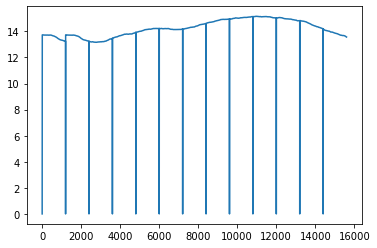

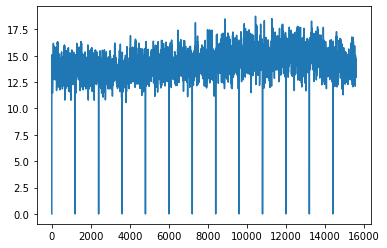

In [12]:
print(ds_cpm.Time)
plt.figure()
plt.plot( ds_cpm.datetime, ds_cpm.wspd.mean(dim = ('x', 'y') ) )

plt.figure()
plt.plot( ds_cpm.datetime, ds_cpm.wspd.isel(x = 400, y = 250, bottom_top = 0)) 


In [13]:
ds_cpm = ds_cpm.isel(datetime = slice(1200, -1))

<xarray.DataArray 'Time' (datetime: 14399)>
dask.array<getitem, shape=(14399,), dtype=int64, chunksize=(3600,), chunktype=numpy.ndarray>
Coordinates:
    Time     (datetime) int64 dask.array<chunksize=(3600,), meta=np.ndarray>
Dimensions without coordinates: datetime


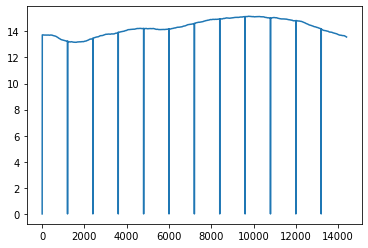

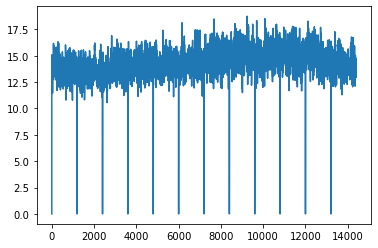

In [14]:
print(ds_cpm.Time)
plt.figure()
plt.plot( ds_cpm.datetime, ds_cpm.wspd.mean(dim = ('x', 'y') ) )

plt.figure()
plt.plot( ds_cpm.datetime, ds_cpm.wspd.isel(x = 400, y = 250, bottom_top = 0)) 


In [15]:
ds_control = ds_control.swap_dims({'nx': 'x', 'ny': 'y'})
ds_control = ds_control.isel( datetime = slice(1200, -1))

In [16]:
ti = 0
tdur = 3600

v_cpm = spatialCorrelation2D(ds_cpm, x0=4500, y0=2000, ti=ti, tf=ti + tdur )#, dateref=dateref)

Performing spatial correlation wrt to point (4495.0, 4495.0), between 0 and 3600.


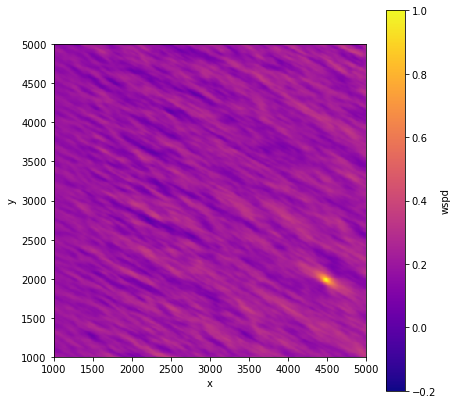

In [17]:


fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(7,7))
v_cpm.wspd.plot(ax=ax, vmin=-0.2, vmax=1, cmap='plasma')

ax.set_ylim([1000, 5000])
ax.set_xlim([1000, 5000])
ax.set_aspect('equal', 'box')



In [18]:
print(v_cpm.max())

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 dask.array<chunksize=(), meta=np.ndarray>
    u        float32 dask.array<chunksize=(), meta=np.ndarray>
    v        float32 dask.array<chunksize=(), meta=np.ndarray>
    w        float32 dask.array<chunksize=(), meta=np.ndarray>
    T        float32 dask.array<chunksize=(), meta=np.ndarray>
    wspd     float32 dask.array<chunksize=(), meta=np.ndarray>
    wdir     float32 dask.array<chunksize=(), meta=np.ndarray>


In [19]:
ti = 0
tdur = 3600

v_con = spatialCorrelation2D(ds_control, x0=4500, y0=2000, ti=ti, tf=ti + tdur )#, dateref=dateref)

Performing spatial correlation wrt to point (4495.0, 4495.0), between 0 and 3600.


In [ ]:


fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(7,7))
v_con.wspd.plot(ax=ax, vmin=-0.2, vmax=1, cmap='plasma')

ax.set_ylim([1000, 5000])
ax.set_xlim([1000, 5000])
ax.set_aspect('equal', 'box')



In [ ]:
print(v_con.max())

In [ ]:
print(ds_cpm.datetime.values)